In [1]:
# this avoids broken pipes by making the default system handler handle the SIGPIPE call
# see https://stackoverflow.com/questions/14207708/ioerror-errno-32-broken-pipe-python
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE, SIG_DFL)

<Handlers.SIG_IGN: 1>

# Kunitz-BPTI domain LB1 project
---

The aim of this project is building an HMM of the Kunitz-BPTI domain starting from structural information.
This HMM wil be then validated against the SwissProt database.
Note that Kunitz-BPTI is a subset of the Kunitz domain.

* Kunitz-BPTI domain in Pfam: `PF00014`
* Uniprot entry of the bovin pancreatic trypsin inhibitor (BPT1_BOVIN): `P00974`
* CATH entry of the Kunitz domain: `4.10.410.10`
* A sample PDB structure:`3TGI`

# Creation of the seed

## PDB search of the PFAM domain
I search on the PDB with the following query:

`Resolution (Å) < 3.5 AND Annotation Identifier equals "PF00014" AND Annotation Type equals "Pfam"`

I retrieve 244 PDB structures.
I save the result in `pdb_ids_pf00014.csv` and I open it here with pandas.
A list of the IDs only is here:

In [ ]:
import pandas as pd

pdb_ids_pf00014 = pd.read_csv("./pdb_ids_pf00014.csv")
pdb_ids_pf00014.head()

I extract a file containing only the IDs, `pdb_ids_pf00014.list`

In [ ]:
with open("./pdb_ids_pf00014.list", "w") as fileout:
    for pdb_id in pdb_ids_pf00014["PDB ID"]:
        fileout.write(pdb_id+"\n")

!head pdb_ids_pf00014.list

## Screening of the results with PDBeFold
In order to remove non-relevant proteins I aligned the structure of the BPTI Kunitz protein 3TGI chain I with all the structures that I retrieved.
The following IDs were not recognised by the server:

`2y2a 2y29 5txd 6nb9`

I manually checked these IDs and they are all peptides or parts of amiloid proteins.
I save the results in `pdbfold_3tgi_pf00014.dat` and I parse it with pandas.
I save the results in fasta format in `pdbfold_3tgi_pf00014.fasta`.

In [ ]:
def get_pdbfold_df(filepath):
    with open(filepath) as dat_filein:
        pdbfold_df = pd.read_csv(dat_filein, skiprows=(0, 1, 2, 3), sep="\s+").set_index('##')
    pdbfold_df["Query"]= pdbfold_df["Query"].str.split(":")
    pdbfold_df["Target"]= pdbfold_df["Target"].str.split(":")
    return pdbfold_df

pdbfold_3tgi_pf00014 = get_pdbfold_df("pdbfold_3tgi_pf00014.dat")
pdbfold_3tgi_pf00014.head()

## Clustering of the sequences with cd-hit

I cluster the seqeunces in the fasta file with cd-hit, to get a series of representatives.
I use default parameters and I get 20 clusters.
It is produced also a .clstr file containing additional info on the clusters.
The representative selected by the software is the one with the longest sequence.

In [ ]:
!cd-hit -i pdbfold_3tgi_pf00014.fasta -o pdbfold_3tgi_pf00014_clustered.fasta

In [ ]:
!head pdbfold_3tgi_pf00014.fasta

In [ ]:
!cat pdbfold_3tgi_pf00014_clustered.fasta|grep ">"

Now I extract the pdb IDs from the clustered output

In [ ]:
!cat pdbfold_3tgi_pf00014_clustered.fasta|grep ">"|awk 'BEGIN {FS=OFS=":"} {print $2, $3}'| cut -d " " -f 1|tee clustered_pdbids.list

## Manual curation of the seed

* 1yld:B mutant BPTI cluster 16
* 1t8l:D mutant BPTI cluster 9
* 5jb7:B mutant BPTI cluster 12
* 1fak:I mutant BPTI cluster 17
* 4u32:X HAI2 KD1, ok
* 4bqd:B TFPI human KD1, ok
* 1yc0:I HAI1 KD2, only domain but ok
* 4dtg:K TFPI human KD2, ok
* 1zjd:B Nexin2 human (amiloid beta precursor) KD, ok
* 5zj3:B Textilinin 2, ok
* 6q61:A cunucotoxin, ok
* 1zr0:B TFPI2 human KD1, ok
* 4u30:X AMBP KD2, ok
* 5yv7:A dendroaspis calcicudine, ok
* 1dtx:A green mamba, ok
* 3m7q:B SHPI-1 from anemone, ok
* 2knt:A KD of human collagen
* 4ntx:B snake toxin MitTx, ok
* 1bun:B beta-bungarotoxin, ok
* 1d0d:A anticoagulant toxin from tick, sequence much different see below analysis

1d0d is a Factor X inhibitor from the tick Ornithodoros moubata its sequence is much different that that of other Kunitz-BPTI domains and in PDBe it is not annotated as Kunitz.
Because of this I will exclude it.
In addition it is complexed with BPTI, so I suspect a missannotation.
Only CATH reports it as BPTI-Kunitz.

I will select only 1 representative for the bovin BPTI, which corresponds to clusters 9, 12, 16, 17.
I will select the longest one that is not mutant.
To do so I first extract the PDB IDs and then is sort them by chain lenght.
I select the longest non-mutants.
Among these, I select the one with the highest resolution.
This happens to be `5pti:a`.

In [ ]:
!cat P00974_clusters.clstr|grep -v "^>"|awk '{print $2, $3}'|awk 'BEGIN{FS=":"}{print $1, $2}'|awk 'BEGIN{FS="aa, >PDB"}{print $1, $2}'|sort -ruk 1

I save the manually edited file in `curated_seed.fasta`.
Now I have 16 sequences.

In [ ]:
!cat curated_seed.fasta|grep ">"|wc -l

In [ ]:
!cat curated_seed.fasta|grep ">"|awk 'BEGIN {FS=OFS=":"} {print $2, $3}'| cut -d " " -f 1 > curated_seed.list

## Structural alignment with PDBeFold
I perform a structural MSA using the PDBeFold webserver.
The alignment is in `pdbfold_seed_msa.seq`.
I save also the xml output of the alignment and the pdb file with the superimposition.
1bun and 4ntx show an RMSD of 1.5, but they are annotated with  PF00014 so I will keep them.

# HMM from the seed alignment
I use hmmbuild to create my HMM from the alignment

In [ ]:
!hmmbuild -n Kunitz-BPTI kunitz_bpti.hmm pdbfold_seed_msa.seq

This is my HMM logo and it is almost identical to the one in Pfam

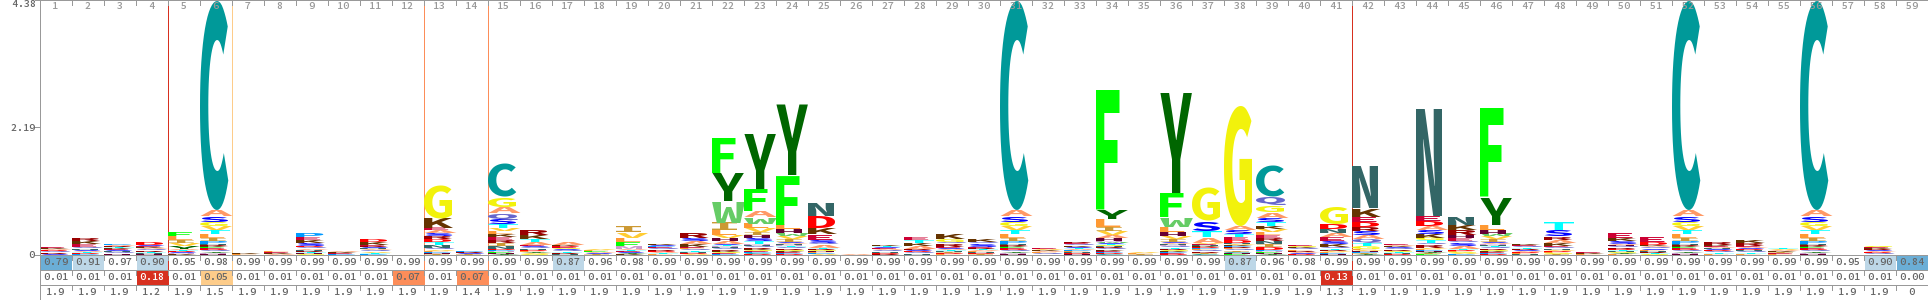

# Creation of the training and testing sets
The professor decided to do a 2-fold crossvalidation ignoring data stratification.
The positives for my model will be all the SwissPort proteins annotated with PF00014. This includes 359 sequences.

`database:(type:pfam pf00014) AND reviewed:yes`

The positives for my model will be all the SwissPort proteins annotated without PF00014. This includes 561552 sequences.

`NOT database:(type:pfam pf00014) AND reviewed:yes`


In [143]:
!cat positives_all.fasta|grep ">"|wc -l

359


In [144]:
!cat negatives_all.fasta|grep ">"|wc -l

561552


## Filtering of seed sequences from the positive set
I want to remove from the positive set the sequences that I used in training.
I can do it by blasting the positives against the curated seed used in building the model.
I will remove all the sequences with 100% local sequence identity with the seed.
The sequence identity should be considered in realtion to the lenght of the matched sequence.
However, selecting a small E-value in the search we are effectively removing short matches.
I wrote a python script for removing the unwanted sequences.

In [8]:
!makeblastdb -in curated_seed.fasta -dbtype prot



Building a new DB, current time: 04/21/2020 15:13:58
New DB name:   /home/saul/currently_working/LB1/project/curated_seed.fasta
New DB title:  curated_seed.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16 sequences in 0.000672102 seconds.


In [11]:
!cat positives_all.fasta|blastp -db curated_seed.fasta -out positives_against_seed.bltab -outfmt 6 -evalue 1e-03

In [ ]:
!cat positives_against_seed.bltab|awk '{if ($3==100){print $1}}' |tee to_be_removed_from_positives.list

In [ ]:
!strip_from_fasta.py positives_all.fasta to_be_removed_from_positives.list|tee positives_all_cleaned.fasta

# Training and validation
I want to build an automated pipeline to do cross-validation and obtain a performance for my model in a rigorous way.
I want to do multiple replicates with random shuffling.
First I prepare a complete dataset containing all my data with E-value and labeled classes.
I create 2 datasets, 1 with global and 1 with local E-value.
I will at the end compare the performance of both.
I use the -Z and -domZ options of hmmsearch to set the database size to the total number of sequences (positives+negatives).

## Data pre-processing in bash

In [2]:
!cat positives_all_cleaned.fasta negatives_all.fasta|grep ">"|wc -l # total size of the database
!cat positives_all_cleaned.fasta|grep ">"|wc -l
!cat negatives_all.fasta|grep ">"|wc -l

561898
346
561552


In [4]:
# initial hmmsearch on the entire datasets
# I use HMM search for obtaining an E-value on all datasets.
# I use the -max flag to disable all heuristics.
!hmmsearch -Z 1 --cpu 8 --max --tblout positives_all_cleaned.hmmsearch.tbl kunitz_bpti.hmm positives_all_cleaned.fasta|tee positives_all_cleaned.hmmsearch|wc -l
!hmmsearch -Z 1 --cpu 8 --max --tblout negatives_all.hmmsearch.tbl kunitz_bpti.hmm negatives_all.fasta|tee negatives_all.hmmsearch|wc -l

5053
1096292


In [5]:
# processing of the results
!hmmalign_to_dataset.sh positives_all_cleaned.hmmsearch.tbl 1 1|tee positives_all_cleaned_local.dat|wc -l
!hmmalign_to_dataset.sh negatives_all.hmmsearch.tbl 0 1|tee negatives_all_local.dat|wc -l
!hmmalign_to_dataset.sh positives_all_cleaned.hmmsearch.tbl 1 0|tee positives_all_cleaned_global.dat|wc -l
!hmmalign_to_dataset.sh negatives_all.hmmsearch.tbl 0 0|tee negatives_all_global.dat|wc -l

346
274032
346
274032


In [6]:
# list of all IDs in the real set
!ID_from_uniprot_fasta.sh positives_all_cleaned.fasta|tee positives_all_cleaned.list|wc -l
!ID_from_uniprot_fasta.sh negatives_all.fasta|tee negatives_all.list|wc -l

346
561552


In [7]:
# complete the dataset with missing IDs
!add_missing_IDs.sh positives_all_cleaned_local.dat positives_all_cleaned.list 10 1|tee positives_all_cleaned_local_complete.dat|wc -l
!add_missing_IDs.sh negatives_all_local.dat negatives_all.list 10 0|tee negatives_all_local_complete.dat|wc -l
!add_missing_IDs.sh positives_all_cleaned_global.dat positives_all_cleaned.list 10 1|tee positives_all_cleaned_global_complete.dat|wc -l
!add_missing_IDs.sh negatives_all_global.dat negatives_all.list 10 0|tee negatives_all_global_complete.dat|wc -l

346
561552
346
561552


In [8]:
# merging of positives and negatives
!cat positives_all_cleaned_local_complete.dat negatives_all_local_complete.dat|tee final_dataset_local.dat|wc -l
!cat positives_all_cleaned_global_complete.dat negatives_all_global_complete.dat|tee final_dataset_global.dat|wc -l

561898
561898


In [11]:
# best and worst results
!echo
!echo "Positives worst local"
!cat final_dataset_local.dat|awk '{if ($3==1){print $0}}'|sort -rgk 2|head
!echo
!echo "Negatives best local"
!cat final_dataset_local.dat|awk '{if ($3==0){print $0}}'|sort -gk 2|head
!echo
!echo "Positives worst global"
!cat final_dataset_global.dat|awk '{if ($3==1){print $0}}'|sort -rgk 2|head
!echo
!echo "Negatives best global"
!cat final_dataset_global.dat|awk '{if ($3==0){print $0}}'|sort -gk 2|head


Positives worst local
D3GGZ8 2.6e-07 1
O62247 3.1e-08 1
Q11101 1.9e-10 1
P86963 1.9e-10 1
P0CH75 2.4e-13 1
Q9BQY6 7e-14 1
P0CAR0 5.4e-14 1
P86964 5.3e-14 1
P26226 4.3e-14 1
H2A0N5 2.9e-14 1

Negatives best local
G3LH89 4.8e-24 0
P56409 3.5e-09 0
P84555 1.1e-08 0
P83605 1.5e-07 0
P85039 3.9e-07 0
P0DJ63 6.1e-07 0
P84556 2.6e-06 0
P36235 2.8e-06 0
P85040 4.1e-06 0
P71089 4.3e-06 0

Positives worst global
D3GGZ8 2.6e-07 1
O62247 7.8e-09 1
Q11101 1.9e-10 1
P86963 1.9e-10 1
P0CH75 2.2e-13 1
Q9BQY6 7e-14 1
P0CAR0 5.4e-14 1
P26226 3.3e-14 1
Q2ES49 1.5e-16 1
Q7Z1K3 1.1e-16 1

Negatives best global
G3LH89 4e-24 0
P56409 3.5e-09 0
P84555 1.1e-08 0
P83605 1.5e-07 0
P85039 3.8e-07 0
P0DJ63 6.1e-07 0
P36235 2.1e-06 0
P71089 2.2e-06 0
P84556 2.6e-06 0
P85040 4.1e-06 0


In [13]:
# just to check that everithing worked out
!model_stats.py final_dataset_local.dat 1e-03
!echo
!model_stats.py final_dataset_global.dat 1e-03

Confusion matrix:
(346, 184)
(561368, 0)

ACC: 0.9996725384322421 MCC: 0.8078466934782291

Confusion matrix:
(346, 312)
(561240, 0)

ACC: 0.9994447390807585 MCC: 0.7249439359384886


## Hard core work in python
I wrote a script that does the optimization and returns a report of the cross-validation on an 80/20 split.
It does 100 randomised replicates.
I also produce a roc curve and a graph of threshold vs MCC.

In [27]:
!cross_val.py Global\ E\ value Best\ domain\ E\ value

Inizialising dataset: Global E value

Splitting the dataset in 5 Kfolds

Training on fold 1
1e-30 0.32960000637130327
1e-27 0.6453815883322533
1e-24 0.8230443674319242
1e-21 0.9068484270401117
1e-18 0.9742924511658673
1e-15 0.9853919024707484
1e-12 0.9927227566696504
1e-09 0.9963680060725786
1e-06 0.992827028754596
0.001 0.7241704418167882
1 0.026284237908432637
Selected threshold: 1e-09

Performance on fold 1
    Training set	Test set
AUC 0.9999999677395398 0.9999968200262029
ACC 0.9999955507899573 0.9999911016195052
MCC 0.9963680060725786 0.9929283531245002
CM [[449242      0]
 [     2    274]] [[112309      1]
 [     0     70]]

Training on fold 2
1e-30 0.323473921124738
1e-27 0.6300510666459567
1e-24 0.8082635701858518
1e-21 0.9052173024743552
1e-18 0.9762450473299689
1e-15 0.9872827508636214
1e-12 0.9927556955311994
1e-09 0.9945733343960319
1e-06 0.9893358953739295
0.001 0.7200207224240345
1 0.026333956704383397
Selected threshold: 1e-09

Performance on fold 2
    Training set	Tes

Strange values in report

## Manual check of the threshold